In [116]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stat

#all files will have this template for their path
file_path = './data/{file_name}'

#get all the csv file names in the data directory
files = os.listdir('./data')
csvs = []
for f in files:
    elems = f.split('.')
    if elems[1] == 'csv':
        csvs.append(f)
        
print('Files:', csvs)

entire_clean_data = pd.DataFrame(columns=['participant', 'correct_resp', 'resp', 'stim_interval', 
                                          'rt', 'vivid_report', 'correct'])

for csv in csvs:
    
    #open and extract relevant columns from each participant's data
    curr_file = pd.read_csv(file_path.format(file_name = csv))
    new_df = curr_file[['participant', 'correct_resp', 'key_resp.keys', 
                        'stim_interval', 'key_resp.rt', 'vivid_report']].copy()
    
    #drop the intro and exit routines
    new_df = new_df.drop([0, 1, 2, 3, 4, 5, 106])
    new_df = new_df.reset_index(drop=True)
    
    #put vividness response on the same line as the content response for each trial
    for i in range(len(new_df.index)):
        if i%2 == 0:
            new_df.at[i, 'vivid_report'] = new_df.at[i + 1, 'vivid_report']
        else:
            new_df = new_df.drop([i])
    new_df = new_df.reset_index(drop=True)
    
    #get rid of any trials where the response was not recorded and correctly format content responses
    for i in range(len(new_df.index)):
        resp = new_df.at[i, 'key_resp.keys']
        viv = new_df.at[i, 'vivid_report']
        if resp == 'None' or viv == '[]':
            new_df = new_df.drop([i])
        else:
            new_df.at[i, 'key_resp.keys'] = float(resp)
    new_df = new_df.reset_index(drop=True)
    
    #tally correct responses and add to df
    corr = []
    for i in range(len(new_df.index)):
        resp = new_df.at[i, 'key_resp.keys']
        ans = new_df.at[i, 'correct_resp']
        if resp == ans:
            corr.append(1.0)
        else:
            corr.append(0.0)
    new_df.insert(loc=len(new_df.columns), column='correct', value=corr, allow_duplicates=True)
    
    #save each participant's cleaned dataset
    new_df = new_df.rename(columns={'key_resp.keys':'resp', 'key_resp.rt':'rt'})
    save_path = './clean_data/{save_name}.csv'
    new_df.to_csv(save_path.format(save_name=csv.split('.')[0] + '_clean'), index=False)
    
    #append to overall dataset
    entire_clean_data = pd.concat([new_df, entire_clean_data], ignore_index=True)
    entire_clean_data.to_csv(save_path.format(save_name='overall_clean'))
    
print('Done cleaning files!')

Files: ['c.csv', 'g.csv', 's.csv', 'gr.csv', 'h.csv']
Done cleaning files!


Participant: s
Number of trials: 50
Overall hit rate: 0.66
One-sample t-test for hit rate >0.5: Ttest_1sampResult(statistic=2.364321853156195, pvalue=0.011035016004515376)
Pearson correlation, duration and hit rate: r = 0.14926980106103524 p-val = 0.554412749506999


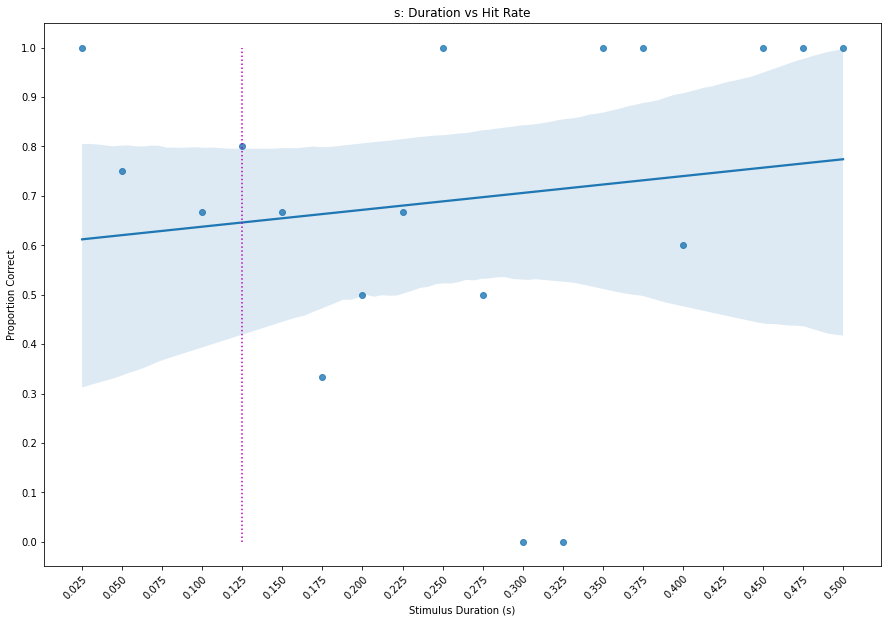

Spearman correlation, vividness and hit rate: r = 1.0 p-val = 0.037264301471748196


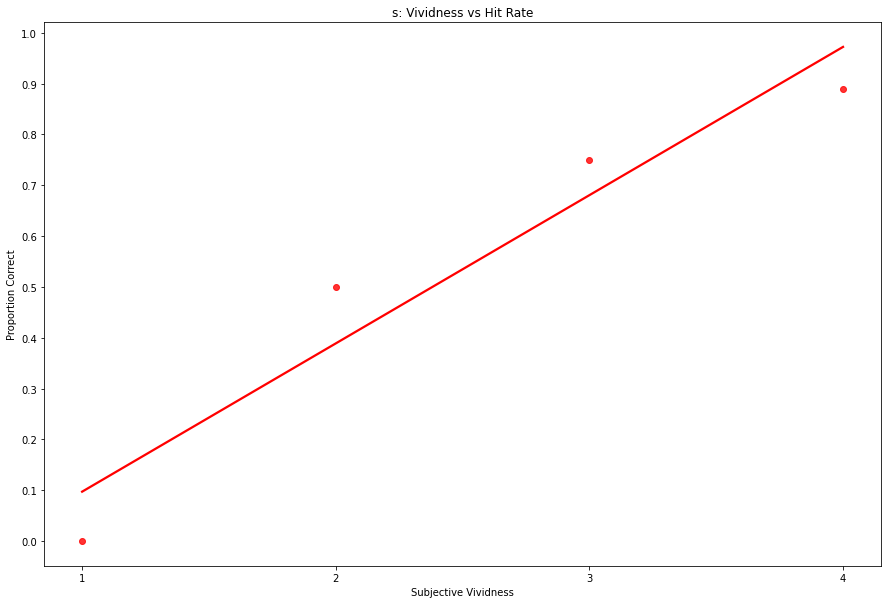

Spearman correlation, duration and vividness: r = 0.5391378361911465 p-val = 0.008032187724035177


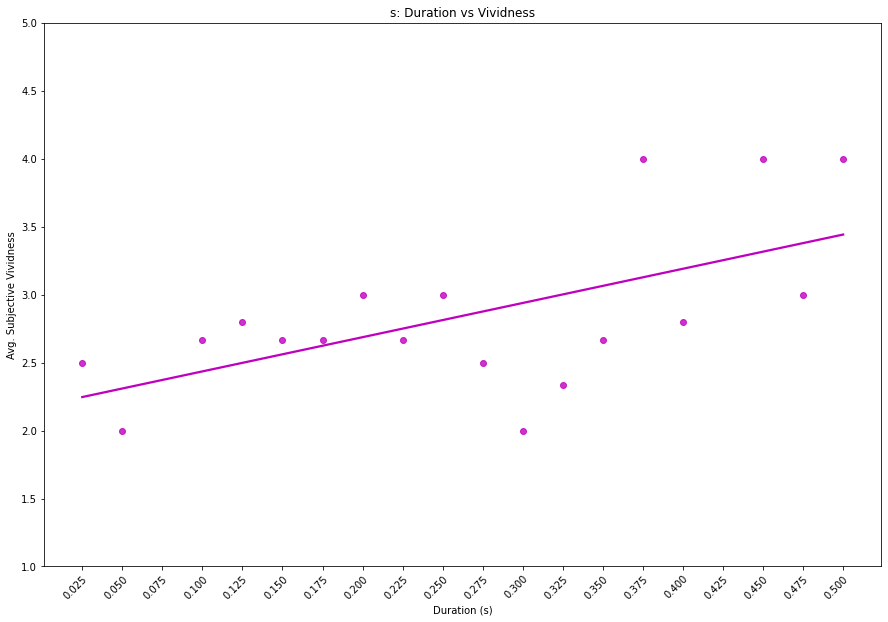



Participant: g
Number of trials: 50
Overall hit rate: 0.54
One-sample t-test for hit rate >0.5: Ttest_1sampResult(statistic=0.5618006477335901, pvalue=0.28840634544129895)
Pearson correlation, duration and hit rate: r = 0.2829316975008835 p-val = 0.2883199196682675


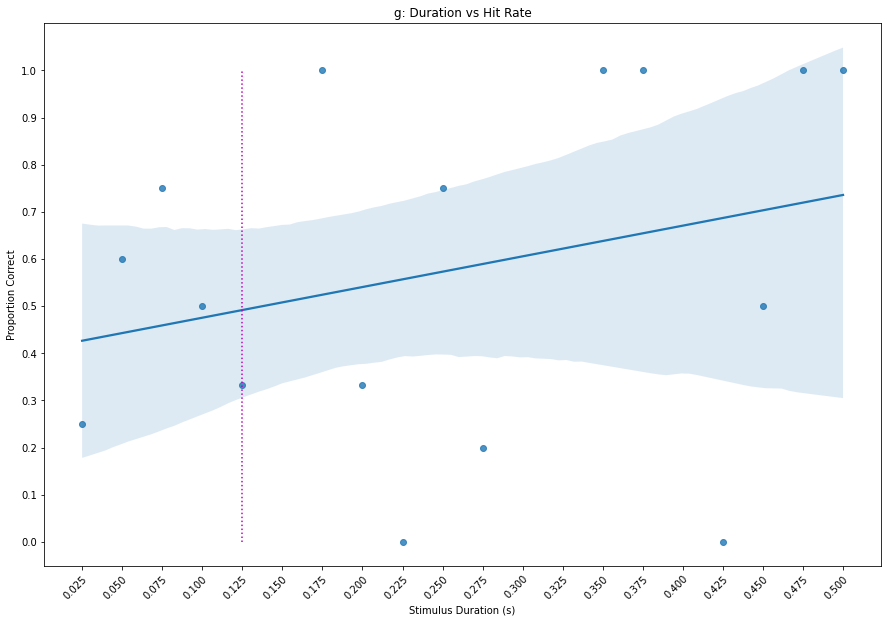

Spearman correlation, vividness and hit rate: r = 0.7999999999999999 p-val = 0.09916781722072987


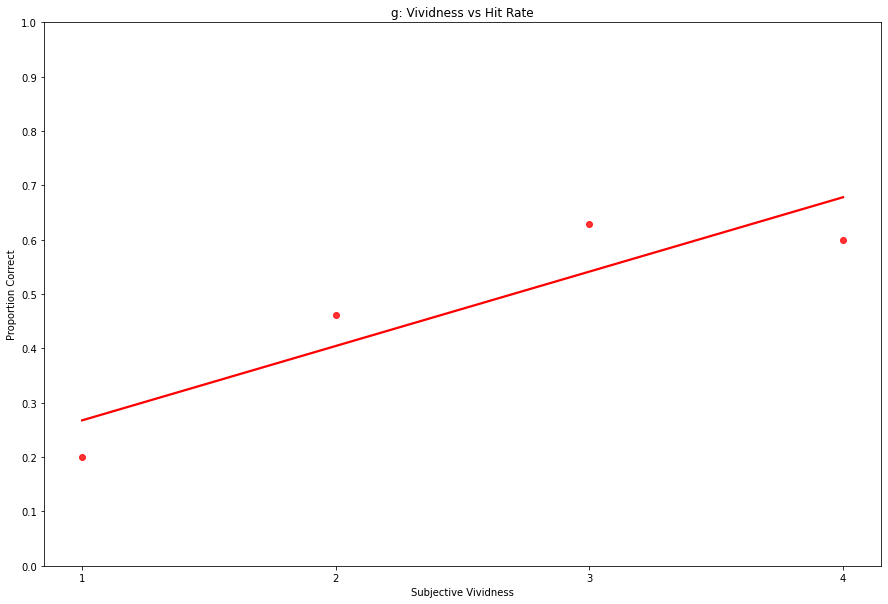

Spearman correlation, duration and vividness: r = 0.42308432982096605 p-val = 0.0424111014711769


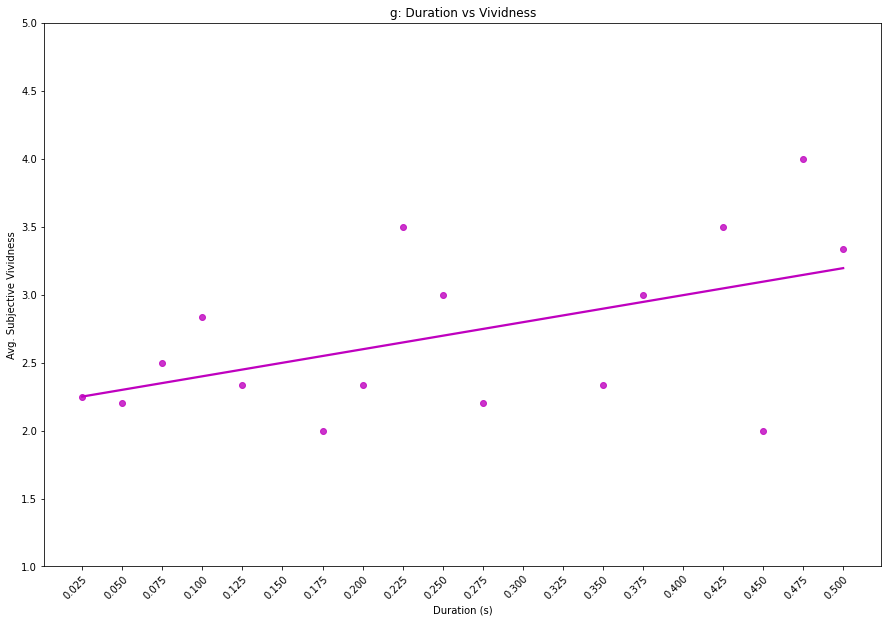



Participant: c
Number of trials: 50
Overall hit rate: 0.58
One-sample t-test for hit rate >0.5: Ttest_1sampResult(statistic=1.1346172578623503, pvalue=0.1310279094963068)
Pearson correlation, duration and hit rate: r = -0.057929999825005005 p-val = 0.8137698482673161


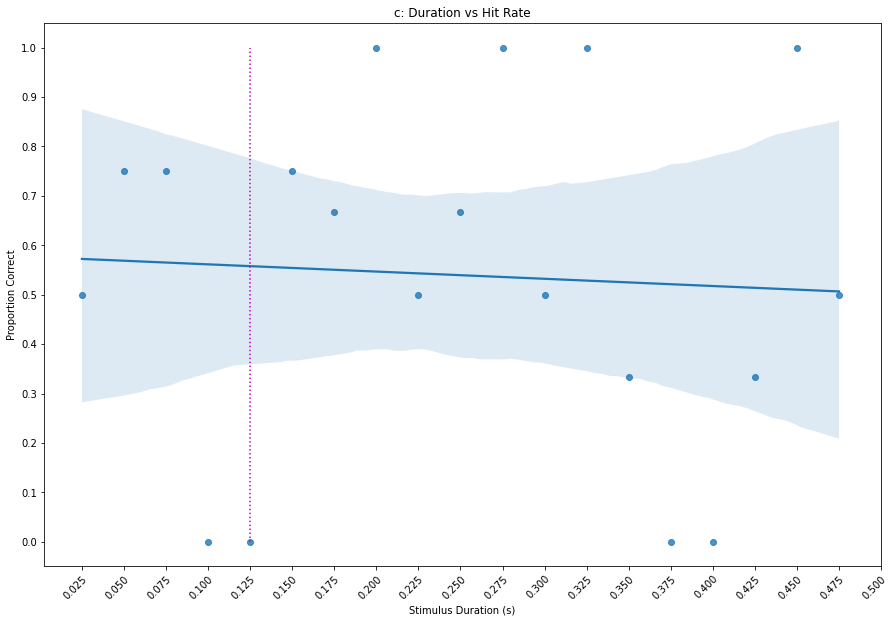

Spearman correlation, vividness and hit rate: r = 0.39999999999999997 p-val = 0.5050106629495906


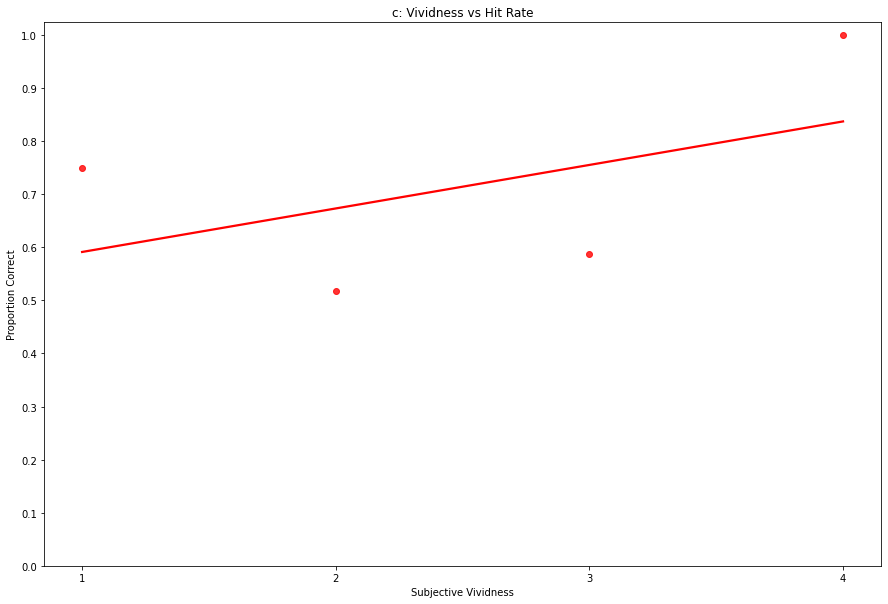

Spearman correlation, duration and vividness: r = -0.4041379337948929 p-val = 0.0992837164745021


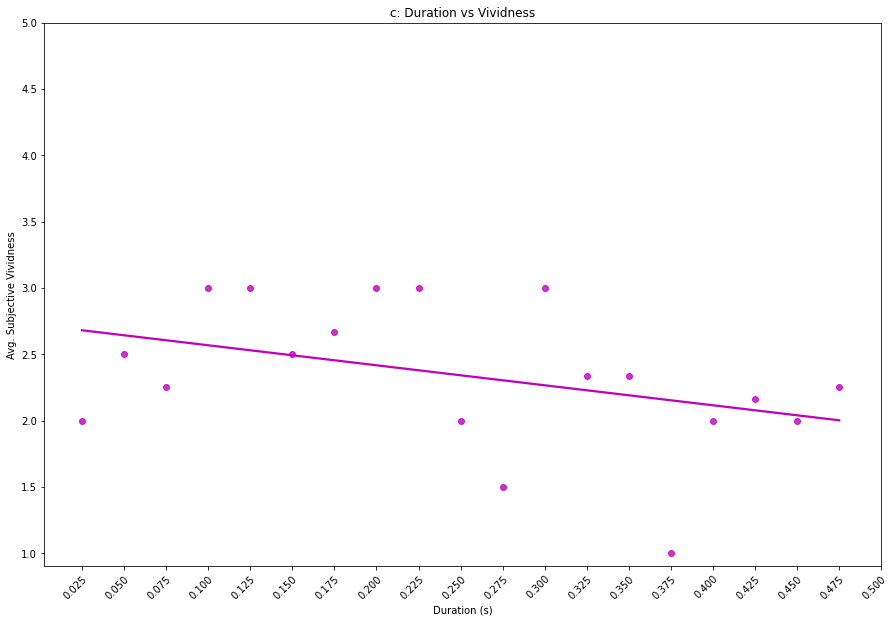



Participant: gr
Number of trials: 46
Overall hit rate: 0.7391304347826086
One-sample t-test for hit rate >0.5: Ttest_1sampResult(statistic=3.653161402852893, pvalue=0.00033672405856386345)
Pearson correlation, duration and hit rate: r = 0.0020221360750091455 p-val = 0.9936463273970655


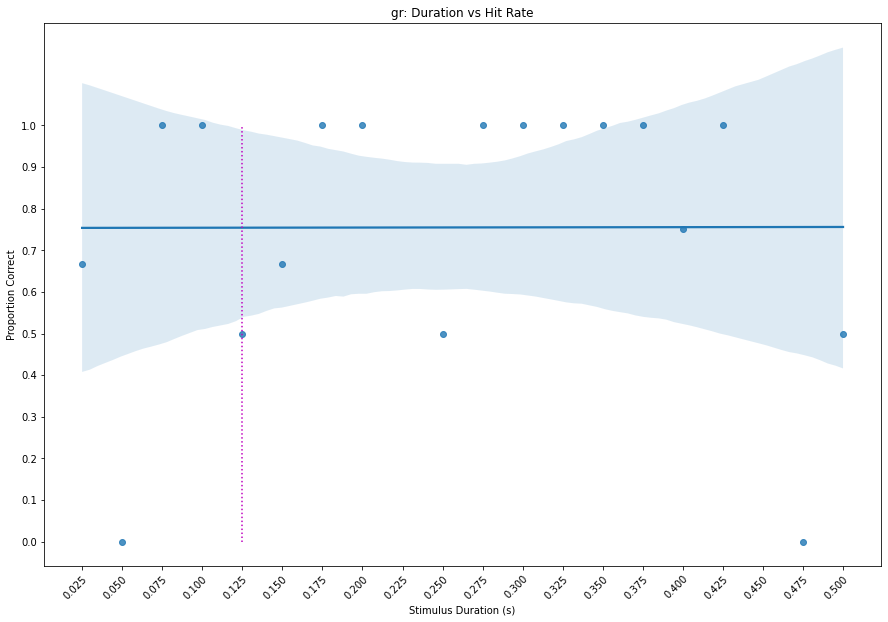

Spearman correlation, vividness and hit rate: r = 0.09999999999999999 p-val = 0.539211637558515


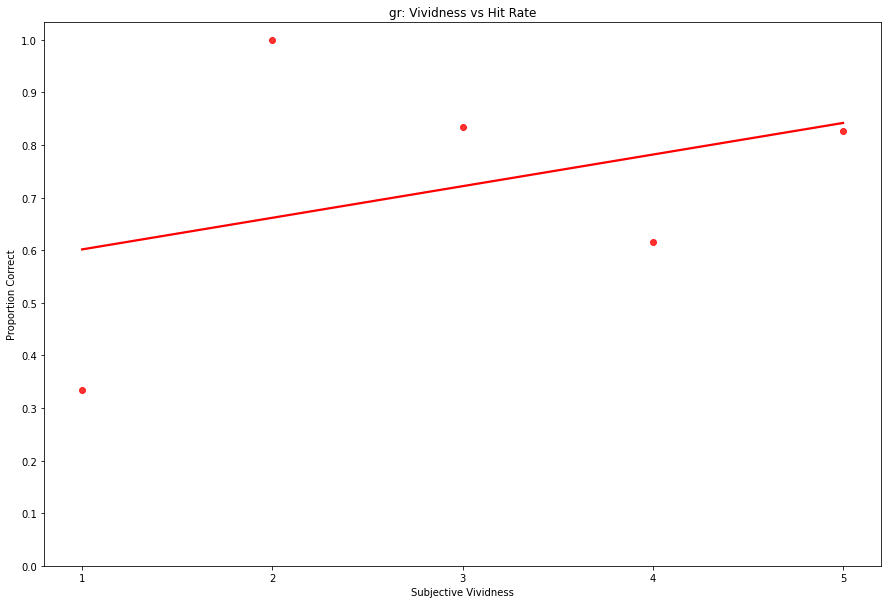

Spearman correlation, duration and vividness: r = 0.061753940031722014 p-val = 0.6994290059046948


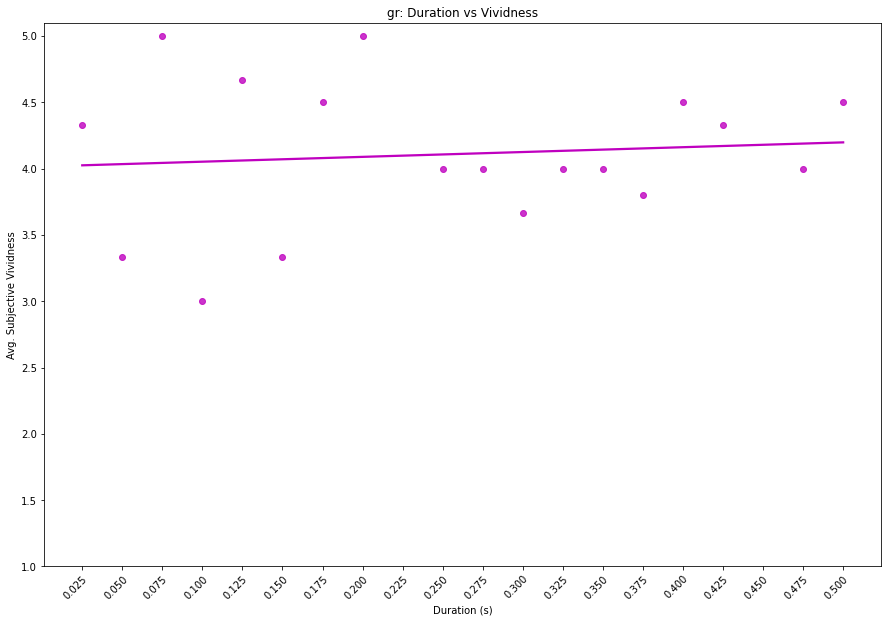



Participant: h
Number of trials: 48
Overall hit rate: 0.6666666666666666
One-sample t-test for hit rate >0.5: Ttest_1sampResult(statistic=2.423839928708164, pvalue=0.009629711741290207)
Pearson correlation, duration and hit rate: r = -0.5277898151545288 p-val = 0.03561788158972637


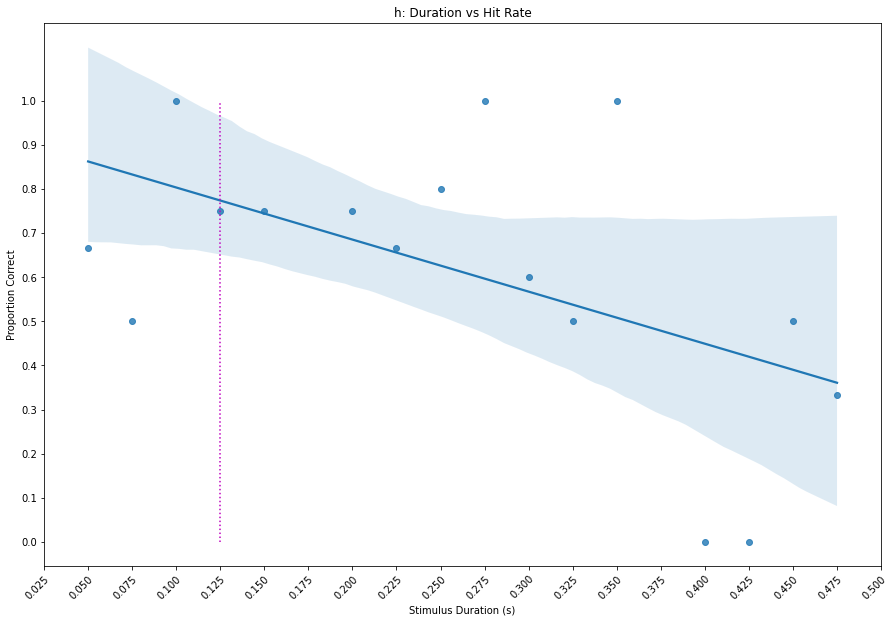

Spearman correlation, vividness and hit rate: r = 1.0 p-val = 0.08663418799913825


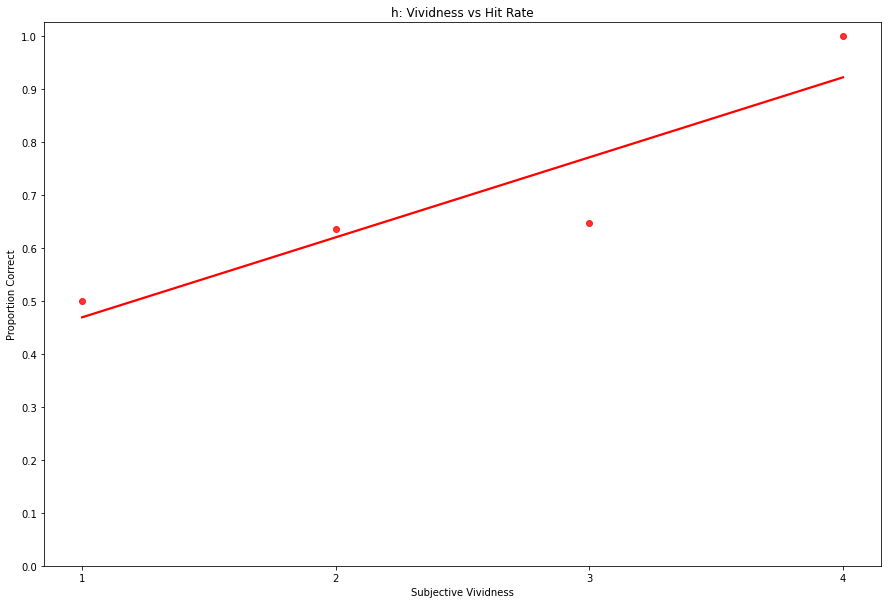

Spearman correlation, duration and vividness: r = 0.528817840554569 p-val = 0.03182082580512733


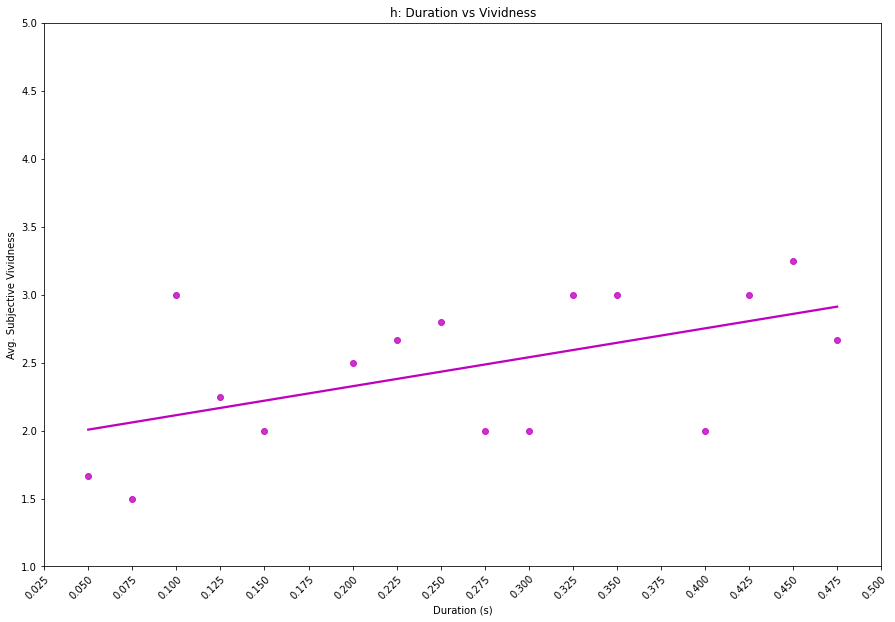



Participant: overall
Number of trials: 244
Overall hit rate: 0.6352459016393442
One-sample t-test for hit rate >0.5: Ttest_1sampResult(statistic=4.379819615266014, pvalue=8.833536558447815e-06)
Pearson correlation, duration and hit rate: r = 0.2252233546981932 p-val = 0.33972012291119125


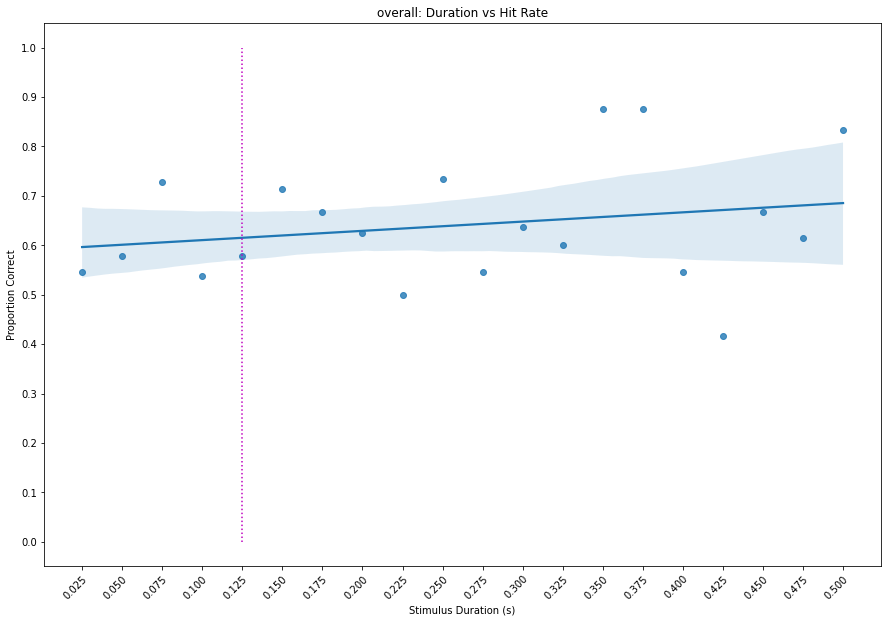

Spearman correlation, vividness and hit rate: r = 0.9999999999999999 p-val = 0.0010332779892891718


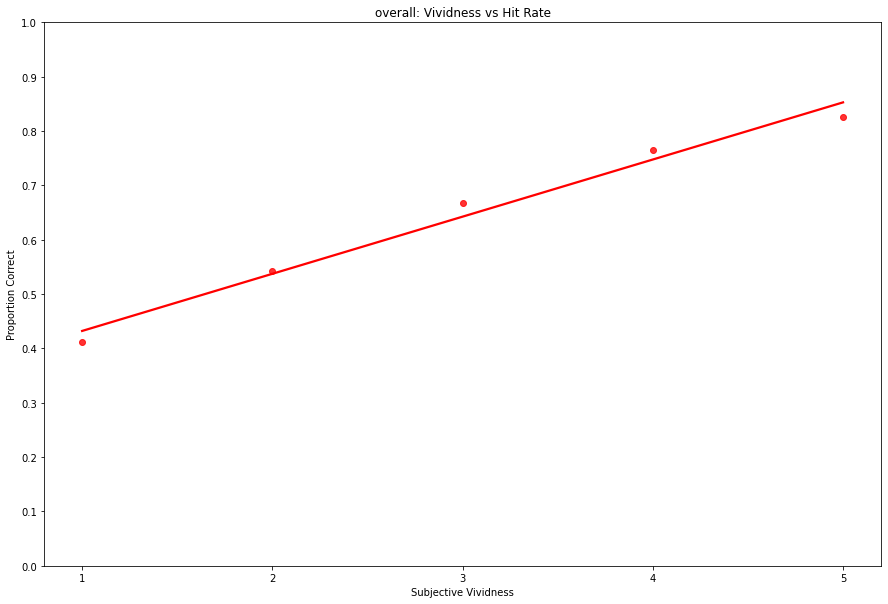

Spearman correlation, duration and vividness: r = 0.4006028639442081 p-val = 0.025554722104683812


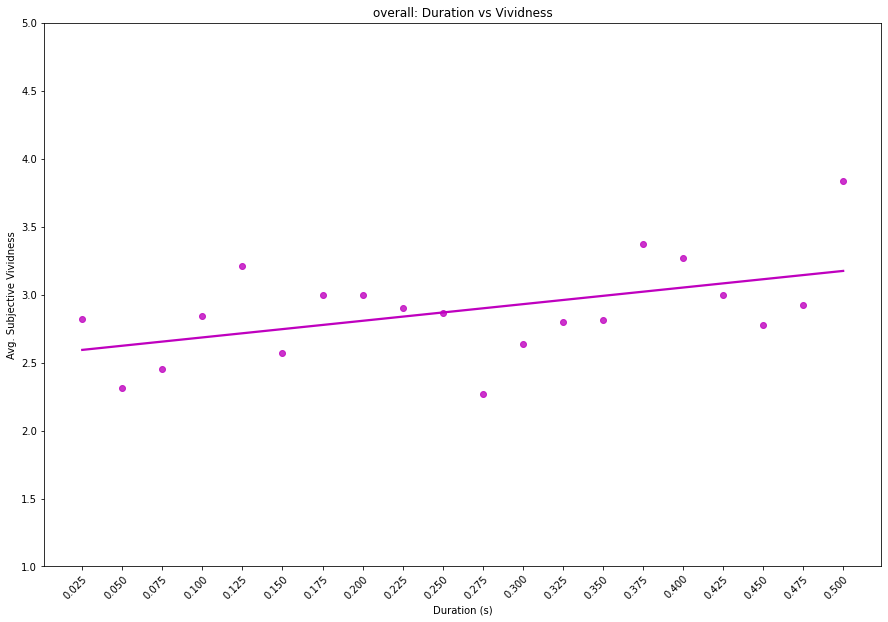

In [117]:
#all files will have this template for their path
file_path = './clean_data/{file_name}'

#get all the csv file names in the clean_data directory
files = os.listdir('./clean_data')
csvs = []
for f in files:
    elems = f.split('.')
    if elems[1] == 'csv':
        csvs.append(f)
csvs.remove('overall_clean.csv')
csvs.append('overall_clean.csv')

part_hr = {}

for i in range(len(csvs)):
    
    #read in each file
    file = csvs[i]
    df = pd.read_csv(file_path.format(file_name=file))
    
    #extract relevant info into lists
    if i != len(csvs) - 1:
        participant = df.at[0, 'participant']
    else:
        participant = 'overall'
    ans = df[['correct_resp']].values.tolist()
    resp = df[['resp']].values.tolist()
    dur = df[['stim_interval']].values.tolist()
    rt = df[['rt']].values.tolist()
    vivid = df[['vivid_report']].values.tolist()
    corr = df[['correct']].values.tolist()
    for i in range(len(df.index)):
        ans[i] = float(ans[i][0])
        resp[i] = float(resp[i][0])
        dur[i] = float(dur[i][0])
        rt[i] = float(rt[i][0])
        vivid[i] = float(vivid[i][0])
        corr[i] = float(corr[i][0])
                   
    #calculate relevant hit rates
    def calc_hr(iv, corr):
        dic1 = {}
        for i in range(len(iv)):
            e = iv[i]
            c = corr[i]
            if e not in dic1:
                dic1[e] = (c, 1)
            else:
                dic1[e] = (dic1[e][0] + c, dic1[e][1] + 1)
        dic2 = {}
        for e in dic1:
            dic2[e] = (dic1[e][0])/(dic1[e][1])
        return dic2
    overall_hr = sum(corr)/len(corr)
    part_hr[participant] = overall_hr
    dur_hr = calc_hr(dur, corr)
    ans_hr = calc_hr(ans, corr)
    resp_hr = calc_hr(resp, corr)
    vivid_hr = calc_hr(vivid, corr)
    dur_vivid = calc_hr(dur, vivid)
    
    #add columns to df for hit rates
    for i in range(len(df.index)):
        p = df.at[i, 'participant']
        s = df.at[i, 'correct_resp']
        r = df.at[i, 'resp']
        d = df.at[i, 'stim_interval']
        v = df.at[i, 'vivid_report']
        df.at[i, 'participant_hr'] = part_hr[p]
        df.at[i, 'stim_hr'] = ans_hr[s]
        df.at[i, 'resp_hr'] = resp_hr[r]
        df.at[i, 'dur_hr'] = dur_hr[d]
        df.at[i, 'viv_hr'] = vivid_hr[v]
    csv_path = './clean_data/{name}_clean.csv'
    csv = csv_path.format(name=participant)
    df.to_csv(csv, index=False)
    
    #show results
    print('Participant:', participant)
    print('Number of trials:', len(df.index))
    print('Overall hit rate:', overall_hr)
    print('One-sample t-test for hit rate >0.5:', stat.ttest_1samp(corr, 0.5, alternative='greater'))
    
    x = list(dur_hr.keys())
    y = list(dur_hr.values())
    print('Pearson correlation, duration and hit rate: r =', stat.pearsonr(x, y)[0],
         'p-val =', stat.pearsonr(x, y)[1])
    title = '{p}: Duration vs Hit Rate'
    fig1, ax1 = plt.subplots(figsize=(15, 10))
    sns.regplot(x=x, y=y, ax=ax1)
    #sns.regplot(x=x, y=y, ax=ax1, logx=True, ci=False)
    ax1.vlines(0.125, 0, 1, colors='m', linestyle='dotted')
    ax1.set_xticks(np.arange(0.025, 0.525, 0.025))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax1.set_yticks(np.arange(0, 1.1, 0.1))
    ax1.set_xlabel('Stimulus Duration (s)')
    ax1.set_ylabel('Proportion Correct')
    ax1.set_title(title.format(p = participant))
    plt.show()
    
    x = list(vivid_hr.keys())
    y = list(vivid_hr.values())
    print('Spearman correlation, vividness and hit rate: r =', stat.spearmanr(x, y)[0],
         'p-val =', stat.pearsonr(x, y)[1])
    title = '{p}: Vividness vs Hit Rate'
    fig2, ax2 = plt.subplots(figsize=(15, 10))
    sns.regplot(x=x, y=y, ax=ax2, ci=False, color='r')
    ax2.set_xticks(np.arange(1, len(x) + 1, 1))
    ax2.set_yticks(np.arange(0, 1.1, 0.1))
    ax2.set_xlabel('Subjective Vividness')
    ax2.set_ylabel('Proportion Correct')
    ax2.set_title(title.format(p = participant))
    plt.show()
    
    x = list(dur_vivid.keys())
    y = list(dur_vivid.values())
    print('Spearman correlation, duration and vividness: r =', stat.spearmanr(x, y)[0],
         'p-val =', stat.pearsonr(x, y)[1])
    title = '{p}: Duration vs Vividness'
    fig3, ax3 = plt.subplots(figsize=(15, 10))
    sns.regplot(x=x, y=y, ax=ax3, ci=False, color='m')
    ax3.set_xticks(np.arange(0.025, 0.525, 0.025))
    plt.setp(ax3.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax3.set_yticks(np.arange(1, 5.5, 0.5))
    ax3.set_xlabel('Duration (s)')
    ax3.set_ylabel('Avg. Subjective Vividness')
    ax3.set_title(title.format(p = participant))
    plt.show()
    
    
    print('\n')